# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [1]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-03-26 19:33:50--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.0.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: 'russian-train-high.1'

     0K .......... .......... .......... .......... ..........  9%  389K 1s
    50K .......... .......... .......... .......... .......... 19%  514K 1s
   100K .......... .......... .......... .......... .......... 28% 4,49M 1s
   150K .......... .......... .......... .......... .......... 38% 6,15M 0s
   200K .......... .......... .......... .......... .......... 48%  885K 0s
   250K .......... .......... .......... .......... .......... 57% 5,67M 0s
   300K .......... .......... .......... .......... .......... 67%  948K 0s
   350K 

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [303]:
def read_infile(infile):
    """
    == YOUR CODE HERE ==
    """
    words = []
    with open(infile, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if ' ' not in line:
                words += line.lower().split('\t')[:-1]
    return words

In [304]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

18426 1834 1844
валлонский валлонскому незаконченный незаконченным истрёпывать истрёпывав личный личного серьга серьгам


In [305]:
def count_chars(words):
    return len(''.join(words))

In [306]:
count_chars(train_words), count_chars(dev_words), count_chars(test_words)

(174617, 17547, 17511)

In [307]:
train_set = set(train_words)
dev_set = set(dev_words)
test_set = set(test_words)

In [308]:
len(train_set), len(dev_set), len(test_set)

(15935, 1733, 1737)

In [309]:
len(dev_set - train_set), len(test_set - train_set)

(1468, 1435)

In [310]:
max(map(len, train_words + dev_words + test_words))

27

In [311]:
min(map(len, train_words + dev_words + test_words))

2

In [312]:
list(filter(lambda x: len(x)==27, train_words + dev_words + test_words))

['информационно-аналитический', 'информационно-аналитическое']

In [313]:
list(filter(lambda x: len(x)==2, train_words + dev_words + test_words))

['ус', 'юз', 'ас', 'ом', 'ат', 'ум']

In [314]:
print(set(''.join(train_set | dev_set | test_set)))

{'х', 'а', 'ь', 'т', 'д', 'е', 'у', 'ю', 'н', '-', 'ъ', 'з', 'ё', 'ж', 'э', 'с', 'ф', 'г', 'м', 'о', 'ц', 'и', 'я', 'в', 'п', 'к', 'ш', 'б', 'й', 'щ', 'л', 'р', 'ы', 'ч'}


In [315]:
len(set(''.join(train_set | dev_set | test_set)))

34

In [316]:
train_words = list(train_set)
dev_words = list(dev_set)
test_words = list(test_set)

**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [317]:
from itertools import count

In [318]:
chars = ['PAD'] + list('абвгдеёжзийклмнопрстуфхцчшщъыьэюя-') + ['BOUND']
char2ind = dict(zip(chars, count()))
ind2char = dict(zip(count(), chars))

In [319]:
class Vocabulary():
    def __init__(self, dct):
        self.dct = dct
        self.bound = [self.dct['BOUND']]
    
    def __call__(self, words):
        if isinstance(words, str):
            return self.bound + [self.dct[char] for char in words] + self.bound
        elif isinstance(words, list):
            return [self.bound + [self.dct[char] for char in word] + self.bound for word in words]
        else:
            raise 'TypeError'

In [320]:
vocab = Vocabulary(char2ind)

In [321]:
vocab(['раз', 'два'])

[[35, 18, 1, 9, 35], [35, 5, 3, 1, 35]]

In [322]:
vocab('раз')

[35, 18, 1, 9, 35]

**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [324]:
import torch
import numpy as np
from torch.utils.data import Dataset as TorchDataset

In [325]:
device = 'cuda'
dtype = torch.long

In [326]:
class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab, dtype=dtype, device=device):
        self.data = data
        self.vocab = vocab
        self.dtype = dtype
        self.device = device
    
    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        """
        == YOUR CODE HERE ==
        """
        word = self.vocab(self.data[index])
        source_tensor = torch.tensor(word[:-1], dtype=dtype, device=device)
        target_tensor = torch.tensor(word[1:], dtype=dtype, device=device)
        
        return source_tensor, target_tensor

    def __len__(self):
        """
        == YOUR CODE HERE ==
        """
        return len(self.data)

In [327]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [328]:
from torch.utils.data import DataLoader

"""
== YOUR CODE HERE ==
"""
train_generator = DataLoader(train_dataset, batch_size=1)
dev_generator = DataLoader(dev_dataset, batch_size=1)
test_generator = DataLoader(test_dataset, batch_size=1)

In [329]:
for i, (x, y) in enumerate(train_generator):
    if i < 10:
        print(f'x size: {x.size()}, y size: {y.size()}')
    else:
        break
print(x)
print(y)

x size: torch.Size([1, 11]), y size: torch.Size([1, 11])
x size: torch.Size([1, 11]), y size: torch.Size([1, 11])
x size: torch.Size([1, 11]), y size: torch.Size([1, 11])
x size: torch.Size([1, 11]), y size: torch.Size([1, 11])
x size: torch.Size([1, 15]), y size: torch.Size([1, 15])
x size: torch.Size([1, 10]), y size: torch.Size([1, 10])
x size: torch.Size([1, 10]), y size: torch.Size([1, 10])
x size: torch.Size([1, 10]), y size: torch.Size([1, 10])
x size: torch.Size([1, 10]), y size: torch.Size([1, 10])
x size: torch.Size([1, 11]), y size: torch.Size([1, 11])
tensor([[35, 19,  1, 12, 18,  1, 13, 30, 15, 16, 11]], device='cuda:0')
tensor([[19,  1, 12, 18,  1, 13, 30, 15, 16, 11, 35]], device='cuda:0')


**(1.5) 1 point** Explain, why this does not work with larger batch size.

Because different words have different lengths, but tensor must contain only equally sized subtensors along any of the axis.

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [330]:
def pad_tensor(vec, length, dim, pad_symbol=0):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    """
    == YOUR CODE HERE ==
    """
    if vec.size(dim) < length:
        pad_size = list(vec.size())
        pad_size[dim] = length - vec.size(dim)
        pad_tensor = torch.zeros(*pad_size, dtype=dtype, device=device)
        return torch.cat([vec, pad_tensor], dim=dim)
    else:
        return vec
    
    
class Padder:
    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def __call__(self, batch):
        """
        == YOUR CODE HERE ==
        """
        x_lens = list(map(lambda x: x[0].shape[self.dim], batch))
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        batch = list(map(lambda x:
                    (pad_tensor(x[0], length=max_len, dim=self.dim), 
                     pad_tensor(x[1], length=max_len, dim=self.dim)), 
                    batch
                ))
        x_pad = torch.stack(list(map(lambda x: x[0], batch)), dim=0)
        y_pad = torch.stack(list(map(lambda x: x[1], batch)), dim=0)
        
        return x_pad, y_pad, x_lens

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [331]:
from torch.utils.data import DataLoader

"""
== YOUR CODE HERE ==
"""
# train_loader = DataLoader(ds, ..., collate_fn=PadCollate(dim=0))
batch_size = 10
train_generator = DataLoader(train_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
dev_generator = DataLoader(dev_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)

In [332]:
for i, (x, y, lens) in enumerate(train_generator):
    if i < 10:
        print(f'x size: {x.size()}, y size: {y.size()}')
    else:
        break
print(x)
print(y)
print(lens)

x size: torch.Size([10, 13]), y size: torch.Size([10, 13])
x size: torch.Size([10, 13]), y size: torch.Size([10, 13])
x size: torch.Size([10, 15]), y size: torch.Size([10, 15])
x size: torch.Size([10, 13]), y size: torch.Size([10, 13])
x size: torch.Size([10, 17]), y size: torch.Size([10, 17])
x size: torch.Size([10, 14]), y size: torch.Size([10, 14])
x size: torch.Size([10, 21]), y size: torch.Size([10, 21])
x size: torch.Size([10, 14]), y size: torch.Size([10, 14])
x size: torch.Size([10, 16]), y size: torch.Size([10, 16])
x size: torch.Size([10, 13]), y size: torch.Size([10, 13])
tensor([[35, 18, 10, 22, 14,  1,  0,  0,  0,  0,  0,  0,  0],
        [35,  9,  1, 14, 16, 25, 15, 29, 11,  0,  0,  0,  0],
        [35, 17, 18,  1, 11, 14,  6, 18,  0,  0,  0,  0,  0],
        [35, 19, 12, 16, 18,  2, 15, 29, 11,  0,  0,  0,  0],
        [35,  1, 12, 18, 16, 19, 20, 10, 23, 16,  3,  0,  0],
        [35, 15, 33, 15, 10,  0,  0,  0,  0,  0,  0,  0,  0],
        [35, 19,  3,  1, 13, 10, 20, 1


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [361]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNLM(nn.Module):

    def __init__(self, vocab_size, hidden_size, embed_dim, batch_size, num_layers=1):
        super(RNNLM, self).__init__()
        """
        == YOUR CODE HERE ==
        """
        self.num_layers = num_layers
        self.char_embeds = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, lens, h_n=None):
        """
        == YOUR CODE HERE ==
        """   
        # inputs : batch_size x seq_len
        batch_size, seq_len = inputs.size()
        embeds = self.char_embeds(inputs) #  batch_size x seq_len x vocab_size
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, lens, batch_first=True, enforce_sorted=False)
        if h_n is None:
            h_n = self.init_hidden(batch_size) # 1 x batch_size x hidden_size
        h_t, h_n = self.gru(embeds, h_n) # batch_size x seq_len x hidden_size
        h_t, _ = pad_packed_sequence(h_t, batch_first=True)
        h_t = h_t.contiguous() # batch_size x seq_len x hidden_size
        x = F.relu(self.fc_1(h_t.view(-1, hidden_size))) # batch_size*seq_len x hidden_size
        y_scores = self.fc_2(x) # batch_size*seq_len x vocab_size
        y_prob = F.log_softmax(y_scores, dim=1) # batch_size*seq_len x vocab_size
        
        return y_prob, h_t, h_n
    
    def init_hidden(self, batch_size):
        h = torch.zeros(1, batch_size, hidden_size, device=device)
        return h

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [362]:
dev_generator = DataLoader(dev_dataset, collate_fn=Padder(), batch_size=len(dev_dataset))

In [363]:
def validate_on_batch(model, criterion, x, y, lens):
    """
    == YOUR CODE HERE ==
    """
    return criterion(model.forward(x, lens)[0], y.view(-1))


def check_val_loss(loader, model, criterion):
    model = model.eval()
    with torch.no_grad():
        for x, y, lens in loader:
            return validate_on_batch(model, criterion, x, y, lens)

**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [364]:
def train_on_batch(model, criterion, x, y, lens, optimizer, i, epoch, t0):
    """
    == YOUR CODE HERE ==
    """
    val_loss = None
    model.zero_grad()
    loss = validate_on_batch(model, criterion, x, y, lens)
    loss.backward()
    optimizer.step()
    if i%100 == 0:
        val_loss = check_val_loss(dev_generator, model, criterion)
        print((f'epoch: {epoch}, iteration: {i},',
               f'time: {datetime.now() - t0}, train_loss: {loss},',
               f'val_loss: {val_loss}'
            ))
    if val_loss:
        return loss, val_loss
    return loss, None

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

In [365]:
from datetime import datetime

In [370]:
epochs = 20
lr = 2e-3
hidden_size = 150
embed_dim = 100
vocab_size = len(char2ind)
model = RNNLM(vocab_size, hidden_size, embed_dim, batch_size)
model = model.to(device=device)

criterion = nn.NLLLoss(ignore_index=0)
# optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr)

In [371]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

In [372]:
batch_size = 20
train_generator = DataLoader(train_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
dev_generator = DataLoader(dev_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)

In [373]:
"""
== YOUR CODE HERE ==
"""
t0 = datetime.now()
losses = []
train_losses = []
val_losses = []
for epoch in range(1, epochs+1):  # again, normally you would NOT do 300 epochs, it is toy data
    for i, (x, y, lens) in enumerate(train_generator):
        model = model.train()
        loss, val_loss = train_on_batch(model, criterion, x, y, lens, optimizer, i, epoch, t0)
        losses.append(loss)
        if val_loss:
            train_losses.append(loss)
            val_losses.append(val_loss)

('epoch: 1, iteration: 0,', 'time: 0:00:00.057872, train_loss: 3.576045513153076,', 'val_loss: 3.5338189601898193')
('epoch: 1, iteration: 100,', 'time: 0:00:03.021101, train_loss: 2.308213472366333,', 'val_loss: 2.392408609390259')
('epoch: 1, iteration: 200,', 'time: 0:00:06.017056, train_loss: 2.0896799564361572,', 'val_loss: 2.2256882190704346')
('epoch: 1, iteration: 300,', 'time: 0:00:08.958215, train_loss: 2.143332004547119,', 'val_loss: 2.1678528785705566')
('epoch: 1, iteration: 400,', 'time: 0:00:11.947338, train_loss: 2.2208800315856934,', 'val_loss: 2.103095531463623')
('epoch: 1, iteration: 500,', 'time: 0:00:14.894962, train_loss: 2.1976702213287354,', 'val_loss: 1.9331189393997192')
('epoch: 1, iteration: 600,', 'time: 0:00:17.830367, train_loss: 2.2570786476135254,', 'val_loss: 2.0275516510009766')
('epoch: 1, iteration: 700,', 'time: 0:00:20.707186, train_loss: 2.0036063194274902,', 'val_loss: 2.2176103591918945')
('epoch: 2, iteration: 0,', 'time: 0:00:23.528671, trai

In [374]:
import matplotlib.pyplot as plt

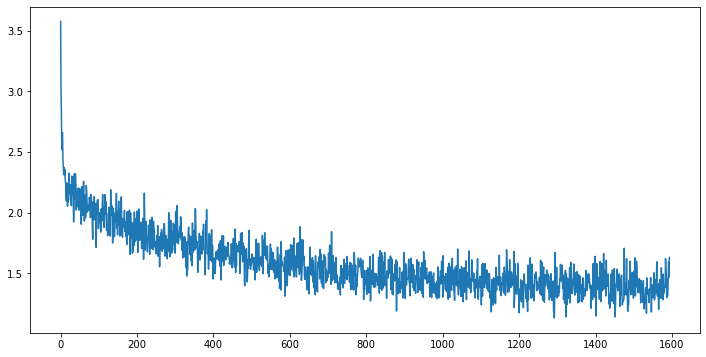

In [375]:
plt.figure(figsize=(12,6))
plt.plot(losses[::10])

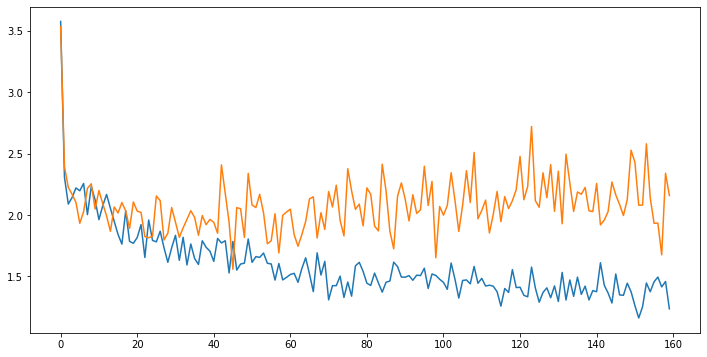

In [376]:
plt.figure(figsize=(12,6))
plt.plot(train_losses)
plt.plot(val_losses)

**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [377]:
"""
== YOUR CODE HERE ==
"""
train_generator = DataLoader(train_dataset, collate_fn=Padder(), batch_size=batch_size)
batches = list(train_generator)
num_batches = len(batches)

In [378]:
np.random.seed(1)
batch = batches[np.random.randint(0, num_batches+1, 1)[0]]

In [379]:
def predict_on_batch(model, batch):
    x_batch, y_batch, lens = batch
    batch_size, max_len = x_batch.shape
    model = model.eval()
    result = []
    with torch.no_grad():
        y, *_ = model.forward(x_batch, lens)
        probs = torch.exp(y[np.arange(y.shape[0]), y_batch.view(-1)]).reshape(batch_size, -1)
    for chars_idxs, chars_probs, word_len in zip(y_batch.cpu(), probs.cpu(), lens):
        result.append([])
        for char_idx, char_prob in zip(chars_idxs[: word_len+1], chars_probs[: word_len+1]):
            if char_idx.item() == char2ind['BOUND']:
                break
            result[-1].append((ind2char[char_idx.item()], char_prob.item()))
    return result

In [380]:
predict_on_batch(model, batch)

[[('з', 0.03613690286874771),
  ('а', 0.8539401888847351),
  ('с', 0.06652694195508957),
  ('т', 0.374347984790802),
  ('а', 0.03415820002555847),
  ('р', 0.3798711597919464),
  ('е', 0.45129165053367615),
  ('л', 0.41478729248046875),
  ('ы', 0.1397506445646286),
  ('й', 0.5739513635635376)],
 [('а', 0.043088071048259735),
  ('в', 0.10837674885988235),
  ('а', 0.1664450466632843),
  ('н', 0.4143446981906891),
  ('п', 0.4056839346885681),
  ('о', 0.9368792772293091),
  ('с', 0.48339685797691345),
  ('т', 0.8019792437553406)],
 [('р', 0.05038710683584213),
  ('а', 0.5836698412895203),
  ('з', 0.47909078001976013),
  ('м', 0.058943815529346466),
  ('я', 0.010030084289610386),
  ('т', 0.721739649772644),
  ('ь', 0.6634500622749329)],
 [('п', 0.16168366372585297),
  ('е', 0.10415658354759216),
  ('р', 0.7433016896247864),
  ('е', 0.9537763595581055),
  ('ш', 0.002762027084827423),
  ('а', 0.27914154529571533),
  ('г', 0.8326393961906433),
  ('н', 0.03217937424778938),
  ('у', 0.50293326377

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [381]:
"""
== YOUR CODE HERE ==
"""
test_generator = DataLoader(test_dataset, collate_fn=Padder(), batch_size=len(test_dataset))
batch = list(test_generator)[0]

In [382]:
test_letter_probs = predict_on_batch(model, batch)

In [383]:
test_letter_probs[:20]

[[('ц', 0.0061201974749565125),
  ('е', 0.7486222386360168),
  ('н', 0.033211540430784225),
  ('т', 0.6001260280609131),
  ('р', 0.796393632888794),
  ('о', 0.029125021770596504),
  ('б', 0.009010003879666328),
  ('е', 0.011784114874899387),
  ('ж', 0.009670182131230831),
  ('н', 0.2571954131126404),
  ('о', 0.3844072222709656),
  ('й', 0.28209057450294495)],
 [('п', 0.16168363392353058),
  ('е', 0.10415660589933395),
  ('р', 0.7433016896247864),
  ('в', 0.007741591893136501),
  ('о', 0.08920121937990189),
  ('к', 3.2914882467594e-05),
  ('л', 0.0012384969741106033),
  ('а', 0.26204508543014526),
  ('с', 0.48841655254364014),
  ('с', 0.5323621034622192),
  ('н', 0.025530461221933365),
  ('ы', 0.23448321223258972),
  ('й', 0.7036784887313843)],
 [('т', 0.037275370210409164),
  ('р', 0.2713366150856018),
  ('у', 0.17555852234363556),
  ('д', 0.2751152217388153),
  ('о', 0.8579317927360535),
  ('в', 0.40698614716529846),
  ('о', 0.7109337449073792),
  ('й', 0.42429956793785095)],
 [('л', 

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [384]:
def generate(model, max_length=20):
    """
    == YOUR CODE HERE ==
    """
    model = model.eval()
    chars = [char2ind['BOUND']]
    hidden = model.init_hidden(1)
    with torch.no_grad():
        for i in range(max_length):
            y, h, hidden = model.forward(torch.tensor([[chars[-1]]], device=device), [1], hidden)
            probs = torch.exp(y[0])
            char = torch.multinomial(probs, 1).item()
            if char == char2ind['BOUND']:
                return chars[1:]
            else:
                chars.append(char)
        return chars[1:]

In [385]:
generate(model, max_length=20)

[16, 12, 18, 16, 3, 10, 26, 30]

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [386]:
for i in range(20):
    """
    == YOUR CODE HERE ==
    """
    print(''.join([ind2char[char_ind] for char_ind in generate(model, max_length=20)]))

тяг
антисемизм
травушка
муэтанныем
ночкретных
монотариям
процешь
серьёзным
уделяла
губнутого
кофического
страчами
фотократический
уричевший
близостер
всхище
опап
атеизнатого
обегора
наплывляемоми


In [387]:
for i in range(20):
    """
    == YOUR CODE HERE ==
    """
    print(''.join([ind2char[char_ind] for char_ind in generate(model, max_length=20)]))

преддавило
щаль
вздевало
рекайской
акционизациям
стрясовые
конзистых
бладовать
засмочом
шкаталя
стостовкой
звеменче
хоругвям
акрыхи
микрое
нехитречни
тюменской
калиловка
придвижеть
конъюнктурным


**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [388]:
def generate_batch(model, batch_size, max_length = 20):
    """
    == YOUR CODE HERE ==
    """
    model = model.eval()
    chars = np.repeat(char2ind['BOUND'], batch_size).reshape(batch_size, 1)
    hidden = model.init_hidden(batch_size)
    with torch.no_grad():
        for i in range(max_length):
            y, h, hidden = model.forward(torch.from_numpy(chars[:,-1:]).cuda().long(), [1]*batch_size, hidden)
            probs = torch.exp(y)
            char = torch.multinomial(probs, 1).cpu().detach().numpy()
            chars = np.concatenate((chars, char), axis=1)
        mask = np.argmax(chars[:, 1:] == char2ind['BOUND'], axis=1) + 1
        return chars, mask

In [389]:
batch_size = 10

In [390]:
chars, mask = generate_batch(model, batch_size, max_length = 20)

In [391]:
chars

array([[35, 18,  1,  9,  5, 18, 16,  2, 13, 32, 35, 35,  1, 32, 12,  1,
        11, 20,  6, 35, 19],
       [35, 16, 12, 18, 21,  4, 13, 29, 14, 35, 10, 19, 20, 10, 25,  6,
        19, 12, 10, 11, 35],
       [35, 18,  1,  9,  2,  6,  9,  8,  3, 21, 25,  1, 20, 30, 19, 33,
        35, 19, 12, 16, 15],
       [35, 17, 18, 16, 18, 20, 15, 29, 11, 35, 12, 18,  1, 13, 30, 12,
        35,  1, 20, 10, 16],
       [35, 17, 16,  5, 19, 13,  6,  5, 19, 20,  3,  6, 15, 15, 29, 11,
        35, 10, 14, 14, 35],
       [35,  2,  6, 19, 19, 20,  1,  3, 15, 16, 11, 35, 21, 15, 33, 20,
        16, 12, 35, 35,  6],
       [35, 17, 18, 16,  4, 15,  6, 20, 35, 30, 12, 16,  4, 16, 35, 21,
        13, 29, 23,  1, 15],
       [35, 16, 17, 21, 23, 15, 29, 11, 35,  6, 35,  1, 18, 16, 14, 12,
        10, 35, 21, 31, 18],
       [35, 14,  1,  9, 33, 20, 30, 35,  1, 18, 10, 33, 35, 27,  1, 23,
        35, 16,  3,  1, 20],
       [35, 16, 18, 10,  6, 15, 20, 10, 18, 16,  3,  1, 20, 30, 19, 33,
        35, 14, 27,

In [392]:
mask

array([10,  9, 16,  9, 16, 11,  8,  8,  7, 16], dtype=int64)

In [393]:
# generated = []
# for _ in range(2):
#     generated += generate_batch(model, batch_size=10)
    

In [394]:
"""
== YOUR CODE HERE ==
"""
chars, masks = generate_batch(model, batch_size, max_length = 20)
for word, mask in zip(chars, masks):
    print("".join([ind2char[char] for char in word[1: mask]]))

самодъят
загребм
орального
заянический
переджурка
полнестовать
вограх
мномялок
примечатает
белоурный


**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.

In [496]:
class RNNLM_LSTM(nn.Module):

    def __init__(self, vocab_size, hidden_size, embed_dim, batch_size, num_layers=1):
        super(RNNLM_LSTM, self).__init__()
        """
        == YOUR CODE HERE ==
        """
        self.num_layers = num_layers
        self.char_embeds = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, vocab_size)
        
        
    def forward(self, inputs, lens, hc_n=None):
        """
        == YOUR CODE HERE ==
        """   
        # inputs : batch_size x seq_len
        batch_size, seq_len = inputs.size()
        embeds = self.char_embeds(inputs) #  batch_size x seq_len x vocab_size
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, lens, batch_first=True, enforce_sorted=False)
        if hc_n is None:
            hc_n = self.init_hc(batch_size) # (1 x batch_size x hidden_size, 1 x batch_size x hidden_size)
        h_t, hc_n = self.lstm(embeds, hc_n)
        h_t, _ = pad_packed_sequence(h_t, batch_first=True)
        h_t = h_t.contiguous() # batch_size x seq_len x hidden_size
        x = F.relu(self.fc_1(h_t.view(-1, hidden_size))) # batch_size*seq_len x hidden_size
        y_scores = self.fc_2(x) # batch_size*seq_len x vocab_size
        y_prob = F.log_softmax(y_scores, dim=1) # batch_size*seq_len x vocab_size
        
        return y_prob, h_t, hc_n
    
    def init_hc(self, batch_size):
        h_n = torch.zeros(self.num_layers, batch_size, hidden_size, device=device)
        c_n = torch.zeros(self.num_layers, batch_size, hidden_size, device=device)
        return (h_n, c_n)

In [506]:
epochs = 20
lr = 2e-3
hidden_size = 150
embed_dim = 100
vocab_size = len(char2ind)
model_lstm = RNNLM_LSTM(vocab_size, hidden_size, embed_dim, batch_size)
model_lstm = model_lstm.to(device=device)
optimizer = optim.Adam(model_lstm.parameters(), lr)

In [507]:
batch_size = 20
train_generator = DataLoader(train_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
dev_generator = DataLoader(dev_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)

In [508]:
"""
== YOUR CODE HERE ==
"""
t0 = datetime.now()
losses = []
train_losses = []
val_losses = []
for epoch in range(1, epochs+1):  # again, normally you would NOT do 300 epochs, it is toy data
    for i, (x, y, lens) in enumerate(train_generator):
        model_lstm.train()
        loss, val_loss = train_on_batch(model_lstm, criterion, x, y, lens, optimizer, i, epoch, t0)
        losses.append(loss)
        if val_loss:
            train_losses.append(loss)
            val_losses.append(val_loss)

('epoch: 1, iteration: 0,', 'time: 0:00:00.064862, train_loss: 3.5817320346832275,', 'val_loss: 3.567594528198242')
('epoch: 1, iteration: 100,', 'time: 0:00:03.040118, train_loss: 2.315737009048462,', 'val_loss: 2.3161416053771973')
('epoch: 1, iteration: 200,', 'time: 0:00:06.000879, train_loss: 2.083756923675537,', 'val_loss: 2.1821084022521973')
('epoch: 1, iteration: 300,', 'time: 0:00:08.991446, train_loss: 2.062284231185913,', 'val_loss: 2.137530565261841')
('epoch: 1, iteration: 400,', 'time: 0:00:11.951087, train_loss: 2.214289665222168,', 'val_loss: 2.212406873703003')
('epoch: 1, iteration: 500,', 'time: 0:00:14.882386, train_loss: 2.0394480228424072,', 'val_loss: 2.175424814224243')
('epoch: 1, iteration: 600,', 'time: 0:00:17.833491, train_loss: 2.0049242973327637,', 'val_loss: 2.173738718032837')
('epoch: 1, iteration: 700,', 'time: 0:00:20.791396, train_loss: 2.114419937133789,', 'val_loss: 2.2799527645111084')
('epoch: 2, iteration: 0,', 'time: 0:00:23.640889, train_los

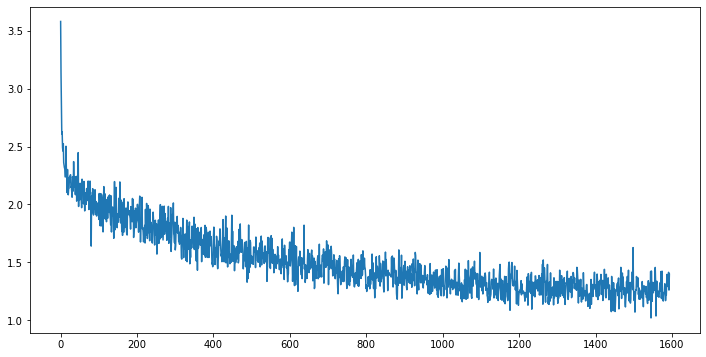

In [509]:
plt.figure(figsize=(12,6))
plt.plot(losses[::10])

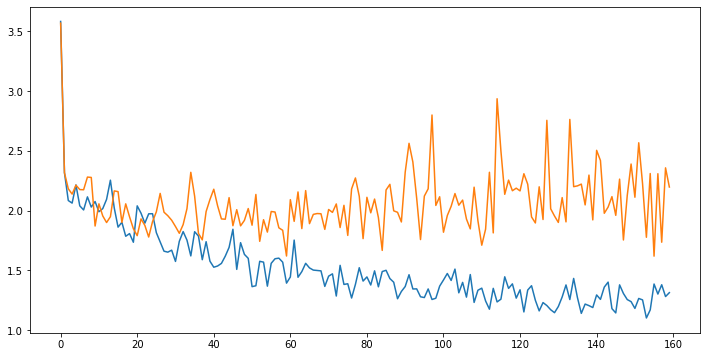

In [510]:
plt.figure(figsize=(12,6))
plt.plot(train_losses)
plt.plot(val_losses)

In [512]:
def generate_lstm(model, max_length=20):
    """
    == YOUR CODE HERE ==
    """
    model = model.eval()
    chars = [char2ind['BOUND']]
    hc_n = model.init_hc(1)
    with torch.no_grad():
        for i in range(max_length):
            y, h_t, hc_n = model.forward(torch.tensor([[chars[-1]]], device=device), [1], hc_n)
            probs = torch.exp(y[0])
            char = torch.multinomial(probs, 1).item()
            if char == char2ind['BOUND']:
                return chars[1:]
            else:
                chars.append(char)
        return chars[1:]

In [513]:
for i in range(20):
    """
    == YOUR CODE HERE ==
    """
    print(''.join([ind2char[char_ind] for char_ind in generate_lstm(model_lstm, max_length=20)]))

классного
видное
командирских
известитель
спитани
упрягало
увлечённой
перещаться
колодчика
раскусывают
съединуть
сготанный
отскоречество
трисашеская
наполнение
сколоть
корыстного
неснашить
гавайцев
равновестной


In [517]:
class RNNLM_LSTM_2(nn.Module):

    def __init__(self, vocab_size, hidden_size, embed_dim, batch_size, num_layers=1):
        super(RNNLM_LSTM_2, self).__init__()
        """
        == YOUR CODE HERE ==
        """
        self.num_layers = num_layers
        self.char_embeds = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.7)
        self.dropout = nn.Dropout(0.7)
        self.fc_1 = nn.Linear(hidden_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, vocab_size)
        
        
    def forward(self, inputs, lens, hc_n=None):
        """
        == YOUR CODE HERE ==
        """   
        # inputs : batch_size x seq_len
        batch_size, seq_len = inputs.size()
        embeds = self.char_embeds(inputs) #  batch_size x seq_len x vocab_size
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, lens, batch_first=True, enforce_sorted=False)
        if hc_n is None:
            hc_n = self.init_hc(batch_size) # (1 x batch_size x hidden_size, 1 x batch_size x hidden_size)
        h_t, hc_n = self.lstm(embeds, hc_n)
        h_t, _ = pad_packed_sequence(h_t, batch_first=True)
        h_t = h_t.contiguous() # batch_size x seq_len x hidden_size
        x = self.dropout(F.relu(self.fc_1(h_t.view(-1, hidden_size)))) # batch_size*seq_len x hidden_size
        y_scores = self.fc_2(x) # batch_size*seq_len x vocab_size
        y_prob = F.log_softmax(y_scores, dim=1) # batch_size*seq_len x vocab_size
        
        return y_prob, h_t, hc_n
    
    def init_hc(self, batch_size):
        h_n = torch.zeros(self.num_layers, batch_size, hidden_size, device=device)
        c_n = torch.zeros(self.num_layers, batch_size, hidden_size, device=device)
        return (h_n, c_n)

In [519]:
epochs = 20
lr = 2e-3
hidden_size = 150
embed_dim = 100
vocab_size = len(char2ind)
model_lstm_2 = RNNLM_LSTM_2(vocab_size, hidden_size, embed_dim, batch_size, num_layers=2)
model_lstm_2 = model_lstm_2.to(device=device)
optimizer = optim.Adam(model_lstm_2.parameters(), lr)

In [520]:
batch_size = 20
train_generator = DataLoader(train_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
dev_generator = DataLoader(dev_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, collate_fn=Padder(), batch_size=batch_size, shuffle=True)

In [521]:
"""
== YOUR CODE HERE ==
"""
t0 = datetime.now()
losses = []
train_losses = []
val_losses = []
for epoch in range(1, epochs+1):  # again, normally you would NOT do 300 epochs, it is toy data
    for i, (x, y, lens) in enumerate(train_generator):
        model_lstm_2.train()
        loss, val_loss = train_on_batch(model_lstm_2, criterion, x, y, lens, optimizer, i, epoch, t0)
        losses.append(loss)
        if val_loss:
            train_losses.append(loss)
            val_losses.append(val_loss)

('epoch: 1, iteration: 0,', 'time: 0:00:00.092783, train_loss: 3.597417116165161,', 'val_loss: 3.577927827835083')
('epoch: 1, iteration: 100,', 'time: 0:00:03.491944, train_loss: 2.895578145980835,', 'val_loss: 2.660926580429077')
('epoch: 1, iteration: 200,', 'time: 0:00:06.918899, train_loss: 2.755758047103882,', 'val_loss: 2.4992616176605225')
('epoch: 1, iteration: 300,', 'time: 0:00:10.281304, train_loss: 2.587045431137085,', 'val_loss: 2.4960083961486816')
('epoch: 1, iteration: 400,', 'time: 0:00:13.622681, train_loss: 2.4764559268951416,', 'val_loss: 2.4536008834838867')
('epoch: 1, iteration: 500,', 'time: 0:00:16.992921, train_loss: 2.30674147605896,', 'val_loss: 2.362563133239746')
('epoch: 1, iteration: 600,', 'time: 0:00:20.317351, train_loss: 2.428471088409424,', 'val_loss: 2.319718599319458')
('epoch: 1, iteration: 700,', 'time: 0:00:23.617563, train_loss: 2.227627992630005,', 'val_loss: 2.2748022079467773')
('epoch: 2, iteration: 0,', 'time: 0:00:26.949247, train_loss:

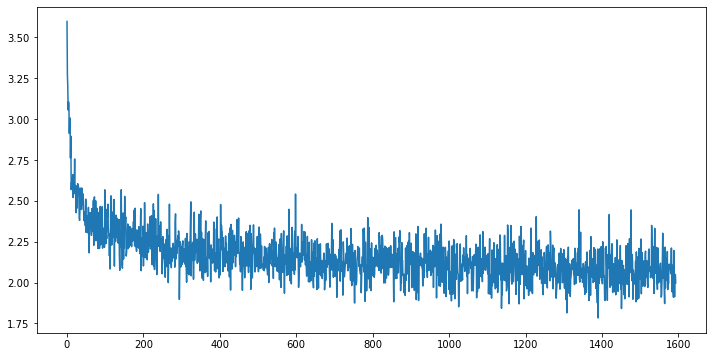

In [522]:
plt.figure(figsize=(12,6))
plt.plot(losses[::10])

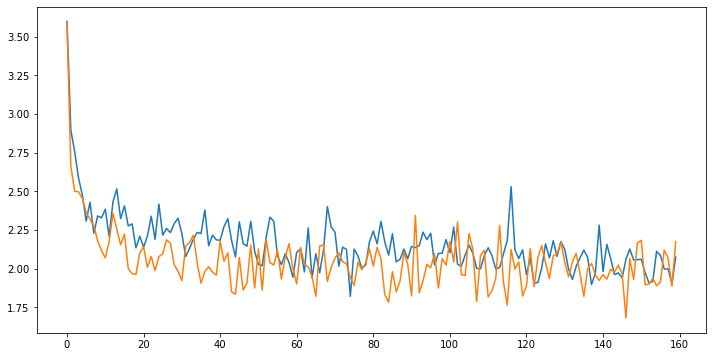

In [523]:
plt.figure(figsize=(12,6))
plt.plot(train_losses)
plt.plot(val_losses)

In [524]:
for i in range(20):
    """
    == YOUR CODE HERE ==
    """
    print(''.join([ind2char[char_ind] for char_ind in generate_lstm(model_lstm_2, max_length=20)]))

предыкловичный
узачовало
расчистить
реграх
лальшенам
дропарной
беснаятный
сстранув
четни
абентникам
клагады
пликаться
абрарнями
загорматся
ватмивости
паролег
оптяти
фраснопострокая
хульном
пропублывать


Последний вариант (2 слоя LSTM + dropout) оказался наименее склонным к переобучению.

In [526]:
'расчистить' in train_words

False